In [43]:
#1. Descriptive analysis of our  data
#Topic: 
#    Prediction rate of volontary termination of pregnancy
#Goal:
#How do geographical and temporal factors influence the rate of voluntary termination of pregnancy at the departmental level, and how can we predict its future evolution ?

#Benfits:
#Prediction can help regional autority to predict the need in infrastructure and medical staff. 
    
#Sources: 
#    Data.drees.solidarites-sante.gouv.fr
#    Système national des données de santé (SNDS) ; traitements Drees
    
    

#Description of the Dataset: 
#Number of rows: 1 121
#Number of columns : 9


#ZONE_GEO : The geographical area covered by the data, a department such as ‘Ain’ or an aggregation such as ‘France entière’ or ‘région’, from 2016 to 2024. Text (Object)
#IVG_HOSP_INS : Number of abortions (IVG) performed in hospital (full hospitalisation) using surgical instruments. Number (Float)
#IVG_HOSP_MED : Number of abortions performed in hospital (inpatient or outpatient) using medication. Number (Float)
#IVG_HOSP_INC :  Number of abortions performed in hospital for unspecified or unknown reasons.    Number (Float)
#IVG_CAB	: Number of abortions performed in a doctor's office or healthcare facility without full hospitalisation. Number (Float)
#IVG_CEN	: Number of abortions performed in family planning or education centres. Number (Float)
#TOT_IVG	: The total number of voluntary terminations of pregnancy recorded for the corresponding GEO_ZONE and year. Number (Float)
#TAUX_rec : The abortion rate. This is generally the number of abortions per 1,000 women of childbearing age (15 to 49 years old). Number (Float)
#annee : The year in which the abortion data was recorded. Number (Int)


In [1]:
#We are importing the data
import pandas as pd

df = pd.read_csv("donnees_feuil1.csv", delimiter=';', encoding='ISO-8859-1')

print(df.head())
print(df.info())

                  ZONE_GEO  IVG_HOSP_INS  IVG_HOSP_MED  IVG_HOSP_INC  IVG_CAB  \
0                      Ain         375.0         715.0           2.0    591.0   
1                    Aisne         313.0        1193.0           5.0    245.0   
2                   Allier         149.0         409.0           2.0    419.0   
3  Alpes-de-Haute-Provence         110.0         262.0           2.0    158.0   
4             Hautes-Alpes          87.0         114.0           2.0    299.0   

   IVG_CEN  TOT_IVG     TAUX_rec   annee  
0    153.0   1836.0  12,86038497  2024.0  
1     13.0   1769.0  17,22308224  2024.0  
2     13.0    992.0  17,02536642  2024.0  
3     62.0    594.0  20,04251442  2024.0  
4     48.0    550.0  21,82020154  2024.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ZONE_GEO      1080 non-null   object 
 1   IVG_HOSP_INS  1

In [45]:
#2. Problèmes de qualité détectés

#TAUX_rec is text with commas to convert to float.

#Some values are missing in all columns.

#We delete each region and total to conserve only departement to avoid biais

In [3]:
#3. Convestion of Taux_rec's separator:
df['TAUX_rec_clean'] = (
    df['TAUX_rec']
    .astype(str)                               
    .str.replace(',', '.', regex=False)       
    .str.replace(r'[^0-9\.]', '', regex=True) 
)


df['TAUX_rec_clean'] = pd.to_numeric(df['TAUX_rec_clean'], errors='coerce')

In [5]:
# 3. Filtrage des lignes agrégées (régions, totaux, etc.)
aggregate_keywords = ["Total", "France entière", "Résidence inconnue", "résidence à l'étranger",
    "Auvergne", "Bourgogne", "Bretagne", "Centre", "Corse", "Grand Est",
    "Guadeloupe", "Guyane", "Hauts-de-France", "Île-de-France", "La Réunion",
    "Martinique", "Mayotte", "Normandie", "Nouvelle-Aquitaine", "Occitanie",
    "Pays de la Loire", "Provence"]

mask = df['ZONE_GEO'].astype(str).str.contains('|'.join(aggregate_keywords), case=False, na=False)
df_filtered =df[mask].copy()

In [7]:
df_cleaned = df_filtered.dropna().copy()

df_cleaned['annee'] = df_cleaned['annee'].astype(int)

print(f"Pré-traitement terminé. Taille du DataFrame nettoyé : {len(df_cleaned)} lignes.")

Pré-traitement terminé. Taille du DataFrame nettoyé : 216 lignes.


In [47]:
#3. Formalisation du problème

#We are going to use linear regression to predict the number of the IVG into a specific region for the next year by using RMSE or MAE
#Also, we going to classify by calculate accuracy, F1-score and confusion Matrix to classify for example regions by high use of IVG and also classify by method

In [9]:
#We realize that we have too many different values for the ZONE-GEO category, so we will first use only the departments and then only the regions.
df["ZONE_GEO"].nunique()

120

In [67]:
#1.we only keep the departmental values
zones_a_exclure = [
    "Total IVG réalisées en France",
    "France entière résidentes",
    "Résidence inconnue",
    "résidence à l'étranger",
    # Anciennes régions (elles existent dans les données historiques)
    "Alsace", "Aquitaine", "Auvergne", "Basse-Normandie", "Bourgogne", "Bretagne",
    "Centre", "Champagne-Ardenne", "Corse", "Franche-Comté", "Haute-Normandie",
    "Ile-de-France", "Languedoc-Roussillon", "Limousin", "Lorraine", "Midi-Pyrénées",
    "Nord-Pas-de-Calais", "Pays de la Loire", "Picardie", "Poitou-Charentes",
    "Provence-Alpes-Côte d'Azur", "Rhône-Alpes",
    # Nouvelles régions (elles sont déjà dans le code de l'étape 2, mais ajoutées ici pour exhaustivité)
    "Auvergne - Rhône-Alpes", "Bourgogne - Franche-Comté", "Bretagne", 
    "Centre - Val de Loire", "Corse", "Grand Est", "Hauts-de-France", 
    "Normandie", "Nouvelle-Aquitaine", "Occitanie", "Pays de la Loire", 
    "Provence - Alpes - Côte d'Azur"
]
exclusion = df['ZONE_GEO'].isin(zones_a_exclure)
df_departements = df[~exclusion].dropna(subset=['TOT_IVG', 'annee', 'TAUX_rec_clean']).copy()
df_departements['annee'] = df_departements['annee'].astype(int)

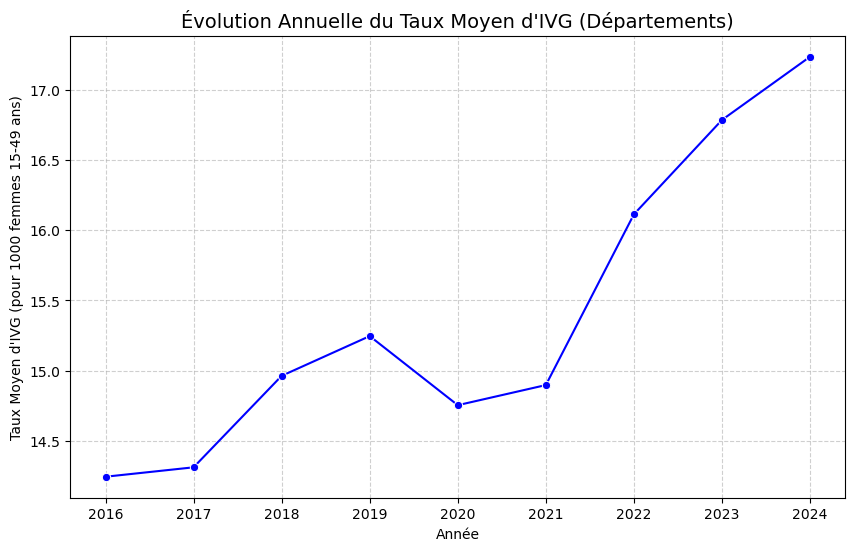

In [71]:
## 1. Évolution Temporelle Moyenne du Taux d'IVG (en utilisant les départements)

# Calcul du taux d'IVG moyen par année
taux_moyen_par_annee = df_departements.groupby('annee')['TAUX_rec_clean'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=taux_moyen_par_annee, x='annee', y='TAUX_rec_clean', marker='o', color='blue')

plt.title('Évolution Annuelle du Taux Moyen d\'IVG (Départements)', fontsize=14)
plt.xlabel('Année')
plt.ylabel('Taux Moyen d\'IVG (pour 1000 femmes 15-49 ans)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(taux_moyen_par_annee['annee']) # Assure que toutes les années sont affichées
plt.show()

C:\Users\nolwenn\AppData\Local\Temp\ipykernel_11260\2924146521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Reds_d')
C:\Users\nolwenn\AppData\Local\Temp\ipykernel_11260\2924146521.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Blues_d')


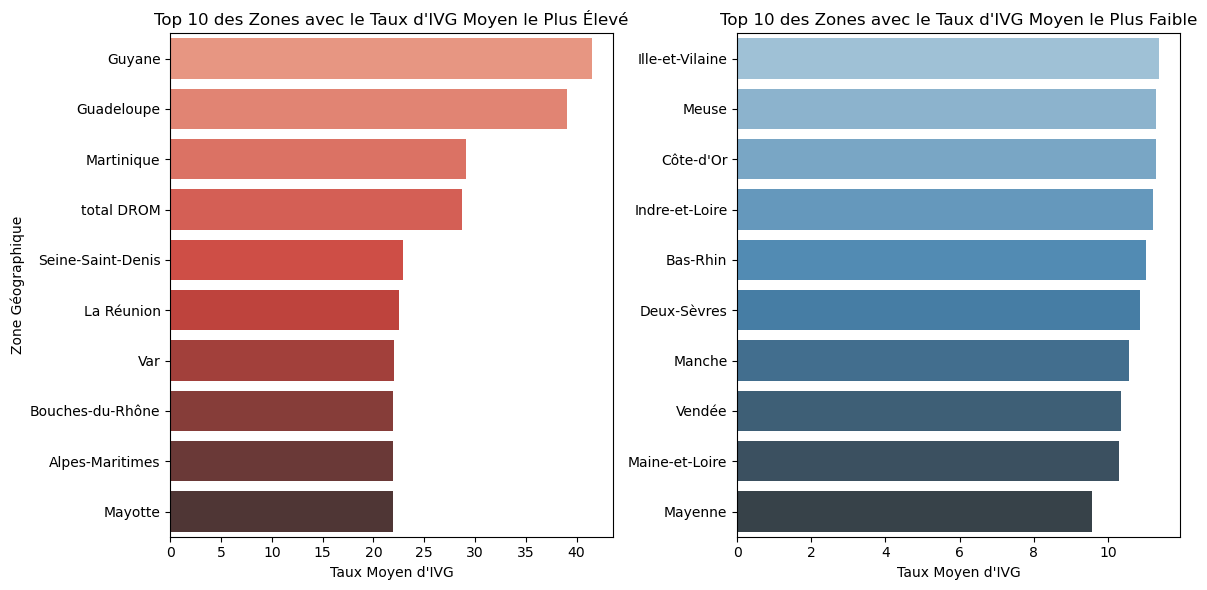

In [49]:
##2. Analyse Départementale du Taux d'IVG

# Calcul du taux d'IVG moyen par ZONE_GEO = départements (sur toutes les années)
taux_moyen_par_zone = df_departements.groupby('ZONE_GEO')['TAUX_rec_clean'].mean().sort_values(ascending=False).reset_index()

# Top 10 des zones avec le taux le plus élevé
top_10 = taux_moyen_par_zone.head(10)
# Top 10 des zones avec le taux le plus faible
bottom_10 = taux_moyen_par_zone.tail(10)

plt.figure(figsize=(12, 6))

# Affichage du TOP 10
plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, 1ère figure
sns.barplot(data=top_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Reds_d')
plt.title('Top 10 des Zones avec le Taux d\'IVG Moyen le Plus Élevé', fontsize=12)
plt.xlabel('Taux Moyen d\'IVG')
plt.ylabel('Zone Géographique')

# Affichage du BOTTOM 10
plt.subplot(1, 2, 2) # 1 ligne, 2 colonnes, 2ème figure
sns.barplot(data=bottom_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Blues_d')
plt.title('Top 10 des Zones avec le Taux d\'IVG Moyen le Plus Faible', fontsize=12)
plt.xlabel('Taux Moyen d\'IVG')
plt.ylabel('') # Retirer le label pour plus de clarté
plt.tight_layout()
plt.show()

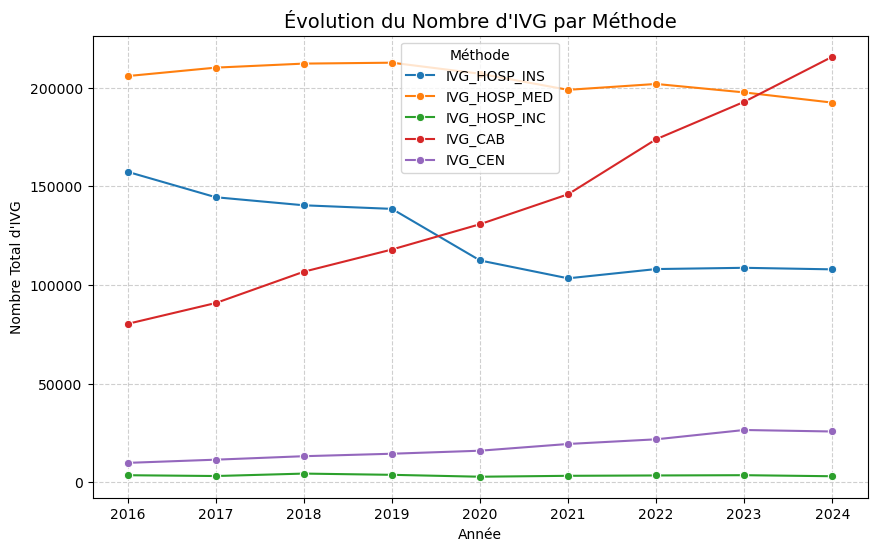

In [51]:
## 3. Analyse de la Distribution des Méthodes d'IVG

# Sélectionner les colonnes des méthodes d'IVG
methodes_cols = ['IVG_HOSP_INS', 'IVG_HOSP_MED', 'IVG_HOSP_INC', 'IVG_CAB', 'IVG_CEN']

# Calculer la somme totale de chaque méthode par année
methodes_annuelles = df_departements.groupby('annee')[methodes_cols].sum().reset_index()

# Préparer les données pour un graphique empilé (Melt)
methodes_melted = methodes_annuelles.melt(
    id_vars='annee',
    value_vars=methodes_cols,
    var_name='Methode_IVG',
    value_name='Nombre_IVG'
)

plt.figure(figsize=(10, 6))
# Créer un graphique à aires empilées pour montrer l'évolution de la proportion
sns.set_palette("tab10")
sns.lineplot(
    data=methodes_melted,
    x='annee',
    y='Nombre_IVG',
    hue='Methode_IVG',
    marker='o'
)

plt.title('Évolution du Nombre d\'IVG par Méthode', fontsize=14)
plt.xlabel('Année')
plt.ylabel('Nombre Total d\'IVG')
plt.legend(title='Méthode')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [27]:
#1.Now we only keep the regional values
regions = [
    "Auvergne -  Rhône-Alpes",
    "Bourgogne -  Franche-Comté",
    "Bretagne",
    "Centre -  Val de Loire",
    "Corse",
    "Grand Est",
    "Hauts-de-France",
    "Ile-de-France",
    "Normandie",
    "Nouvelle-Aquitaine",
    "Occitanie",
    "Pays de la Loire",
    "Provence - Alpes - Côte d'Azur"
]

df_regions = df[df["ZONE_GEO"].isin(regions)].copy()
df_regions["ZONE_GEO"].nunique()


13


Classement des régions par Taux Moyen d'IVG (du plus élevé au plus faible) :
                          ZONE_GEO  TAUX_rec_clean
0   Provence - Alpes - Côte d'Azur       21.606959
1                    Ile-de-France       17.860030
2                            Corse       17.273115
3                        Occitanie       16.854175
4               Nouvelle-Aquitaine       14.149686
5                  Hauts-de-France       13.783525
6          Auvergne -  Rhône-Alpes       13.651088
7           Centre -  Val de Loire       13.595329
8       Bourgogne -  Franche-Comté       12.800469
9                        Normandie       12.623903
10                       Grand Est       12.351502
11                        Bretagne       12.014057
12                Pays de la Loire       11.144015


C:\Users\nolwenn\AppData\Local\Temp\ipykernel_11260\1119273273.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


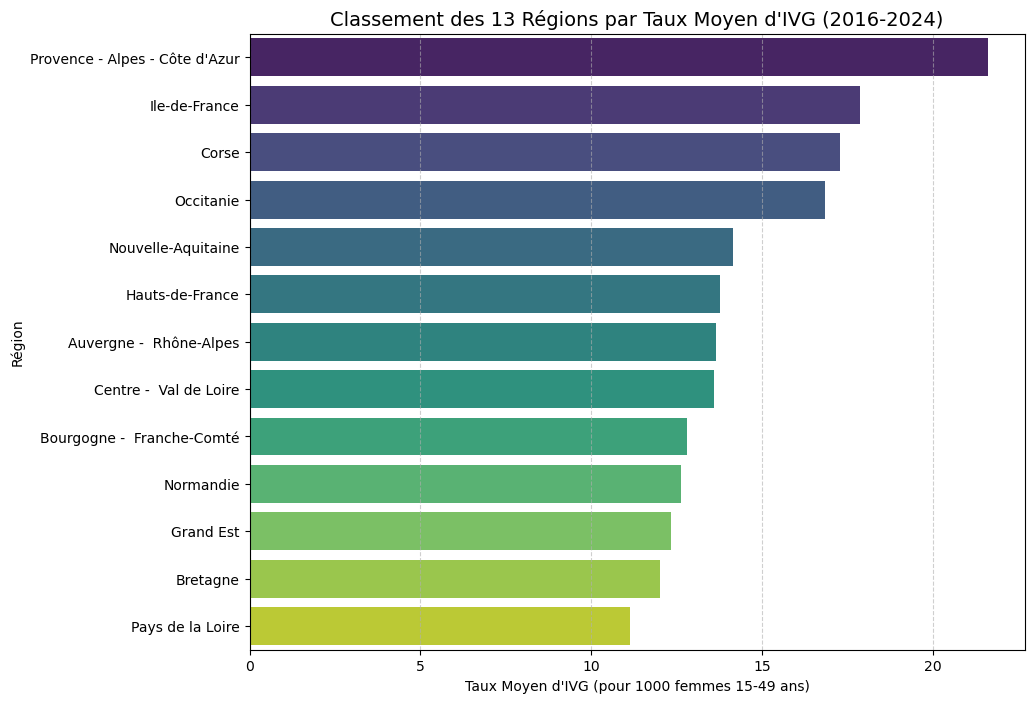

In [53]:
# --- 2. Calcul du Taux Moyen d'IVG par Région ---
# Calculer la moyenne du taux d'IVG pour chaque région sur toutes les années
taux_moyen_par_region = df_regions.groupby('ZONE_GEO')['TAUX_rec_clean'].mean().sort_values(ascending=False).reset_index()

# Afficher les données triées
print("\nClassement des régions par Taux Moyen d'IVG (du plus élevé au plus faible) :")
print(taux_moyen_par_region)

# --- 3. Visualisation sur un seul graphique ---
plt.figure(figsize=(10, 8))

# Utiliser un barplot pour visualiser le classement
sns.barplot(
    data=taux_moyen_par_region,
    x='TAUX_rec_clean',
    y='ZONE_GEO',
    palette='viridis' # Une palette de couleurs plus simple
)

plt.title('Classement des 13 Régions par Taux Moyen d\'IVG (2016-2024)', fontsize=14)
plt.xlabel('Taux Moyen d\'IVG (pour 1000 femmes 15-49 ans)')
plt.ylabel('Région')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

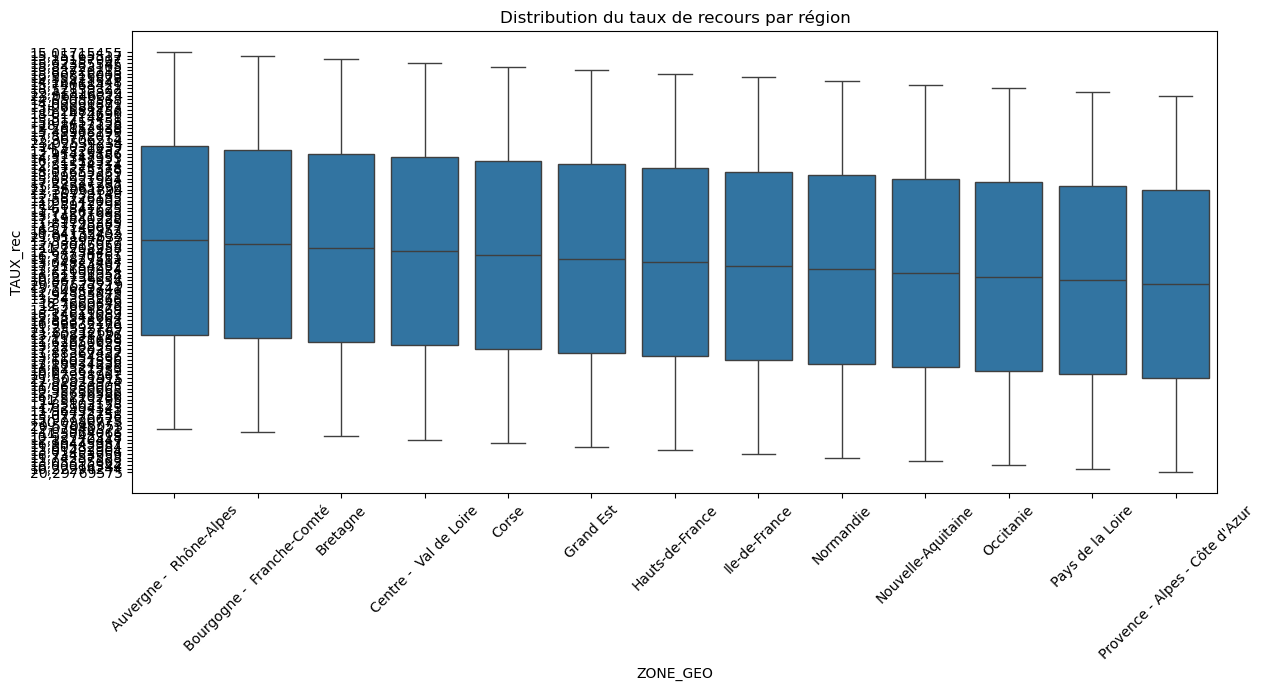

In [29]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14,6))
sns.boxplot(data=df_regions, x="ZONE_GEO", y="TAUX_rec")
plt.xticks(rotation=45)
plt.title("Distribution du taux de recours par région")
plt.show()

C:\Users\nolwenn\AppData\Local\Temp\ipykernel_11260\2304427814.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_mean.index, y=region_mean.values, palette='viridis')


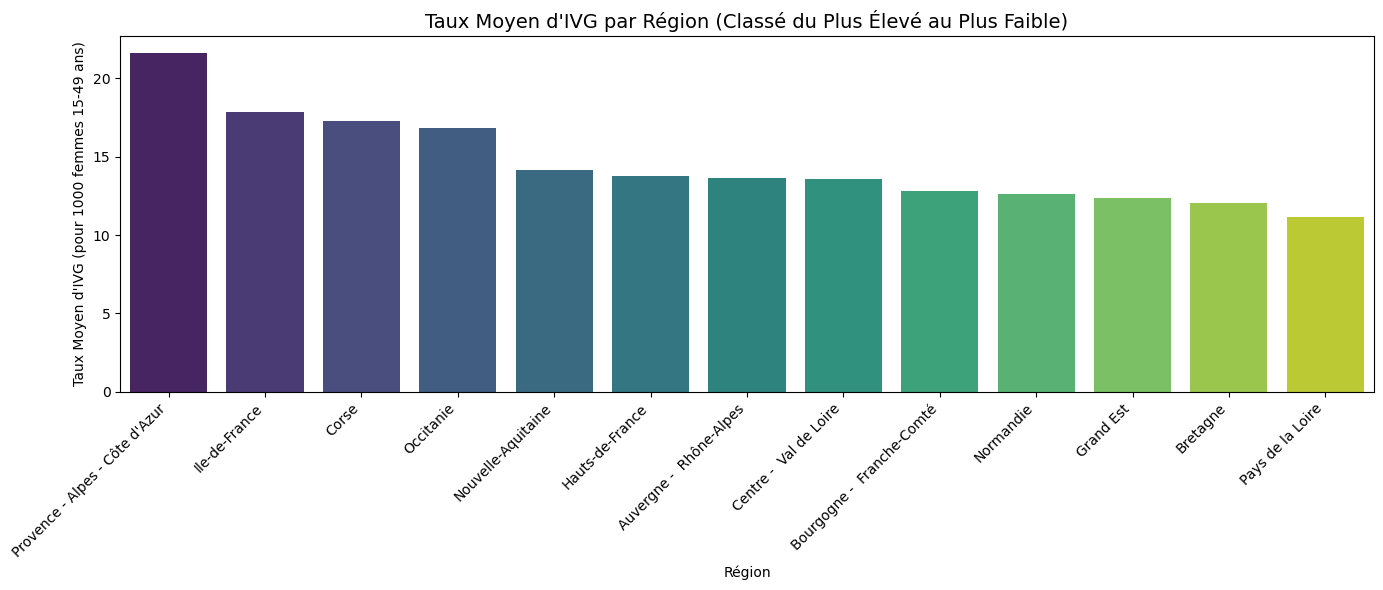

In [55]:
# Assurez-vous que df_regions est bien le DataFrame filtré sur les régions avec Taux_rec_clean

# 1. Calcul du taux moyen par région, trié en ordre décroissant (du plus élevé au plus faible)
region_mean = df_regions.groupby("ZONE_GEO")["TAUX_rec_clean"].mean().sort_values(ascending=False)

# 2. Préparation et affichage du graphique
plt.figure(figsize=(14,6))

# Création du graphique à barres
sns.barplot(x=region_mean.index, y=region_mean.values, palette='viridis')

# Rotation des labels de l'axe X pour qu'ils soient lisibles
plt.xticks(rotation=45, ha='right')

plt.title("Taux Moyen d'IVG par Région (Classé du Plus Élevé au Plus Faible)", fontsize=14)
plt.xlabel("Région")
plt.ylabel("Taux Moyen d'IVG (pour 1000 femmes 15-49 ans)")
plt.tight_layout() # Ajuste automatiquement les paramètres du graphique
plt.show()

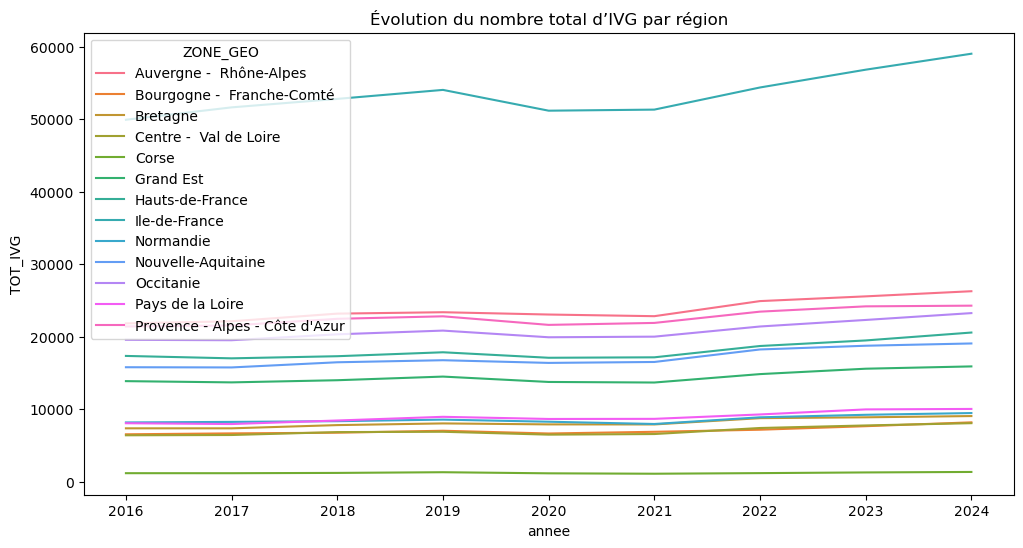

In [31]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_regions, x="annee", y="TOT_IVG", hue="ZONE_GEO")
plt.title("Évolution du nombre total d’IVG par région")
plt.show()


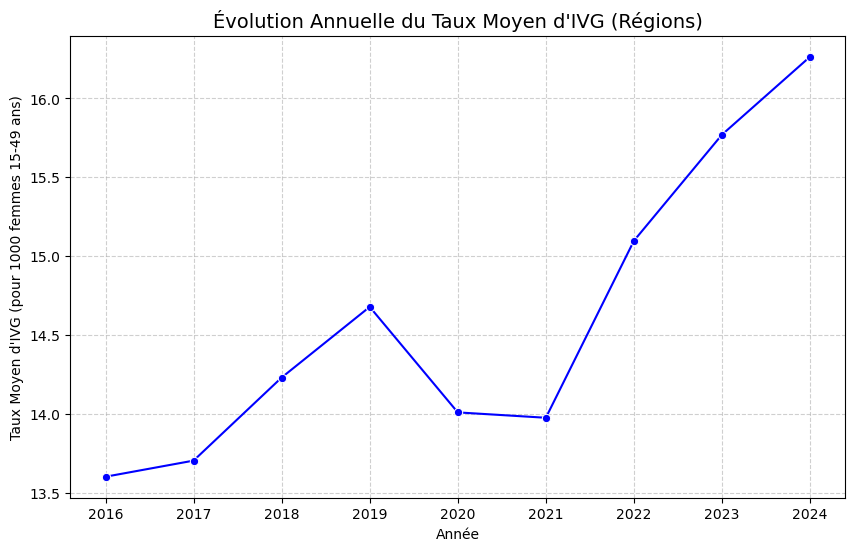


Année de la plus forte variation du taux moyen:
TAUX_rec_clean    2022.0
dtype: float64
TAUX_rec_clean    2020.0
dtype: float64


In [41]:
## 📈 1. Évolution Temporelle Moyenne du Taux d'IVG

# Calculer le taux d'IVG moyen par année
taux_moyen_par_annee = df_regions.groupby('annee')['TAUX_rec_clean'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=taux_moyen_par_annee, x='annee', y='TAUX_rec_clean', marker='o', color='blue')

plt.title('Évolution Annuelle du Taux Moyen d\'IVG (Régions)', fontsize=14)
plt.xlabel('Année')
plt.ylabel('Taux Moyen d\'IVG (pour 1000 femmes 15-49 ans)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(taux_moyen_par_annee['annee']) # Assure que toutes les années sont affichées
plt.show()

# Exemple: Identifier la plus forte augmentation/diminution
taux_diff = taux_moyen_par_annee.set_index('annee').diff().iloc[1:]
print("\nAnnée de la plus forte variation du taux moyen:")
print(taux_diff.idxmax())
print(taux_diff.idxmin())

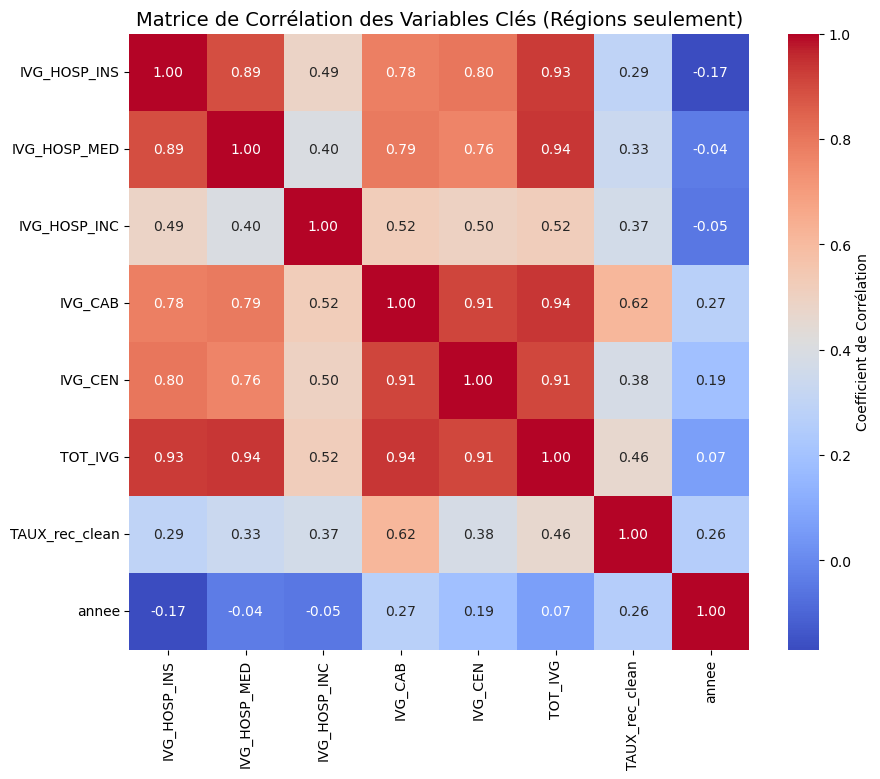

In [57]:
# --- 1. Sélection des colonnes numériques pertinentes ---
colonnes_corr = [
    'IVG_HOSP_INS', 
    'IVG_HOSP_MED', 
    'IVG_HOSP_INC', 
    'IVG_CAB', 
    'IVG_CEN', 
    'TOT_IVG', 
    'TAUX_rec_clean', # Utilisation de la colonne nettoyée
    'annee'
]

# Calcul de la matrice de corrélation (uniquement sur les colonnes sélectionnées)
correlation_matrix = df_regions[colonnes_corr].corr()

# --- 2. Visualisation avec une Heatmap ---
plt.figure(figsize=(10, 8)) # Agrandir légèrement la figure pour plus de lisibilité
sns.heatmap(
    correlation_matrix, 
    annot=True,              # Afficher les coefficients
    cmap="coolwarm",         # Palette
    fmt=".2f",               # Formatage à deux décimales
    cbar_kws={'label': 'Coefficient de Corrélation'} # Légende de la barre de couleur
)

plt.title("Matrice de Corrélation des Variables Clés (Régions seulement)", fontsize=14)
plt.show()


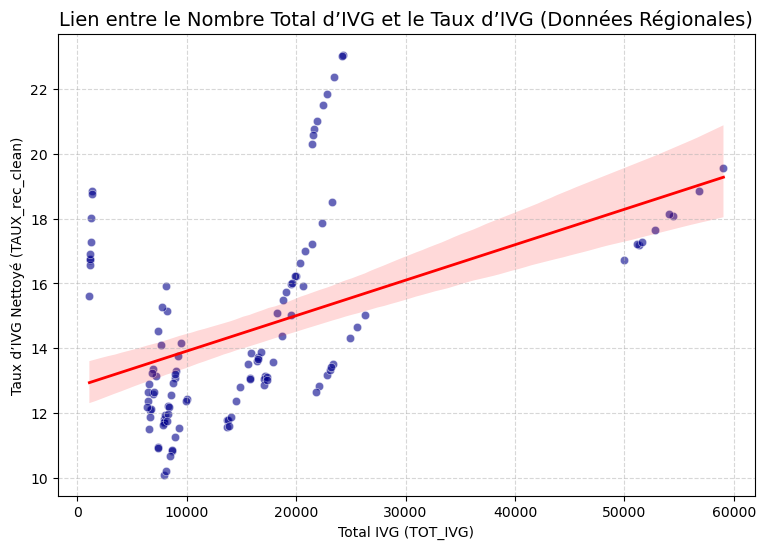

In [63]:
# Nous allons créer un DataFrame propre pour le graphique
# Nous sélectionnons uniquement les colonnes nécessaires et retirons les NaN juste pour ce graphique
df_plot = df_regions[['TOT_IVG', 'TAUX_rec_clean']].dropna()

# --- 1. Visualisation de la Relation entre le Total IVG et le Taux IVG ---
plt.figure(figsize=(9,6))

# Nuage de points
sns.scatterplot(
    data=df_plot, 
    x="TOT_IVG", 
    y="TAUX_rec_clean",
    alpha=0.6, # Rendre les points semi-transparents
    color="darkblue"
)

# Ajout de la droite de régression (pour montrer la tendance)
# 'scatter=False' permet de ne dessiner que la ligne de tendance et son intervalle de confiance
sns.regplot(
    data=df_plot, 
    x="TOT_IVG", 
    y="TAUX_rec_clean", 
    scatter=False, 
    color="red",
    line_kws={'lw': 2} # Épaissit la ligne
)

plt.title("Lien entre le Nombre Total d’IVG et le Taux d’IVG (Données Régionales)", fontsize=14)
plt.xlabel("Total IVG (TOT_IVG)")
plt.ylabel("Taux d’IVG Nettoyé (TAUX_rec_clean)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


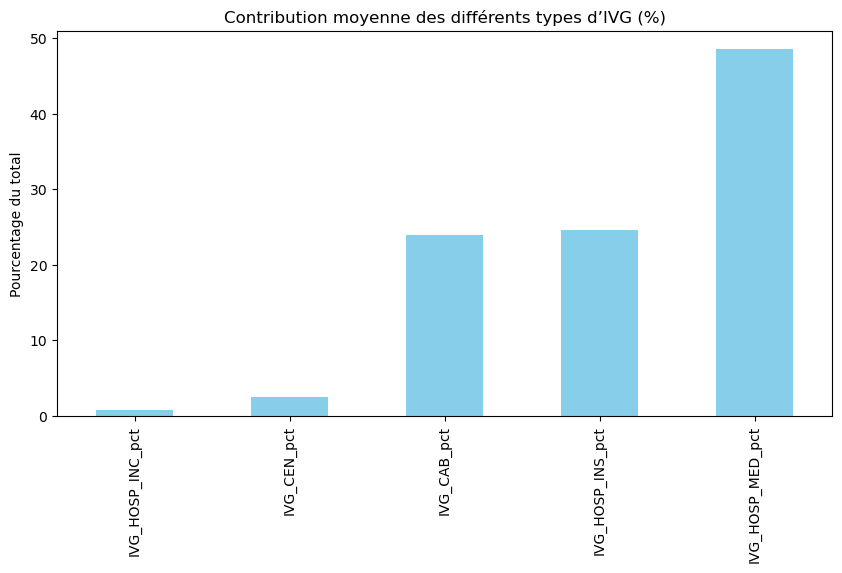

In [65]:
#Contribution des types d’IVG au total

df_types = df[["IVG_HOSP_INS","IVG_HOSP_MED","IVG_HOSP_INC","IVG_CAB","IVG_CEN","TOT_IVG"]].copy()

for col in ["IVG_HOSP_INS","IVG_HOSP_MED","IVG_HOSP_INC","IVG_CAB","IVG_CEN"]:
    df_types[col+"_pct"] = df_types[col] / df_types["TOT_IVG"] * 100

contrib_cols = [c for c in df_types.columns if "_pct" in c]

df_contrib_mean = df_types[contrib_cols].mean()

plt.figure(figsize=(10,5))
df_contrib_mean.sort_values().plot(kind="bar", color="skyblue")
plt.title("Contribution moyenne des différents types d’IVG (%)")
plt.ylabel("Pourcentage du total")
plt.show()

In [ ]:
4. Selection of a baseline model and implementation of the model.

Prediction of IVG rate 
by department, year and eventually type of IVG
it's multiple linear regression

Classification
Classify a department for a specific year. 
Decision tree or logistic regression

In [59]:
#baseline Linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

df_cleaned['TAUX_rec'] = (
    df_cleaned['TAUX_rec']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']


test_year = 2024
X_train = X[X['annee'] < test_year]
X_test = X[X['annee'] == test_year]
y_train = y[X['annee'] < test_year]
y_test = y[X['annee'] == test_year]


X_full = pd.get_dummies(X, columns=['ZONE_GEO'], drop_first=True)
X_train_processed = X_full.loc[X_train.index]
X_test_processed = X_full.loc[X_test.index]


baseline_model = LinearRegression()
baseline_model.fit(X_train_processed, y_train)


y_pred = baseline_model.predict(X_test_processed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Le RMSE du modèle de référence sur les données de 2024 est : {rmse:.4f}")

Le RMSE du modèle de référence sur les données de 2024 est : 2.0493


In [61]:
#baseline classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


test_year = 2024
df_train = df_cleaned[df_cleaned['annee'] < test_year].copy()
df_test = df_cleaned[df_cleaned['annee'] == test_year].copy()


tertiles = df_train['TAUX_rec'].quantile([0.33, 0.66])
Q1 = tertiles.iloc[0]
Q2 = tertiles.iloc[1]


def categorize_taux(taux):
    if taux <= Q1:
        return 'Faible'
    elif taux <= Q2:
        return 'Moyen'
    else:
        return 'Élevé'


df_cleaned['TAUX_CLASS'] = df_cleaned['TAUX_rec'].apply(categorize_taux)

X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_CLASS']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ],
    remainder='passthrough'
)

# Créer le Pipeline (Pré-traitement + Modèle de Classification)

model_classification = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', multi_class='auto', random_state=42))
])


model_classification.fit(X_train, y_train)
y_pred_class = model_classification.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_class)

print(f"\n--- Résultat du Modèle de Classification Baseline (Régression Logistique) ---")
print(f"Quantiles utilisés pour la classification (Q1: {Q1:.2f}, Q2: {Q2:.2f})")
print(f"Précision (Accuracy) sur l'année 2024 : {accuracy:.4f}")
print("\n--- Rapport de Classification (Détails) ---")
print(classification_report(y_test, y_pred_class))


--- Résultat du Modèle de Classification Baseline (Régression Logistique) ---
Quantiles utilisés pour la classification (Q1: 14.05, Q2: 18.45)
Précision (Accuracy) sur l'année 2024 : 0.6250

--- Rapport de Classification (Détails) ---
              precision    recall  f1-score   support

      Faible       0.33      1.00      0.50         3
       Moyen       0.57      0.40      0.47        10
       Élevé       1.00      0.73      0.84        11

    accuracy                           0.62        24
   macro avg       0.63      0.71      0.60        24
weighted avg       0.74      0.62      0.64        24



In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# --- Nettoyage de la cible ---
df_cleaned['TAUX_rec'] = (
    df_cleaned['TAUX_rec']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# --- Features + target ---
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']

# --- Split temporel ---
test_year = 2024
X_train = X[X['annee'] < test_year]
X_test  = X[X['annee'] == test_year]
y_train = y[X['annee'] < test_year]
y_test  = y[X['annee'] == test_year]

# --- One-hot encoding ---
X_full = pd.get_dummies(X, columns=['ZONE_GEO'], drop_first=True)
X_train_processed = X_full.loc[X_train.index]
X_test_processed  = X_full.loc[X_test.index]

# --- Modèle LASSO ---
lasso_model = Lasso(alpha=0.1)   # tu peux tuner alpha
lasso_model.fit(X_train_processed, y_train)

# --- Prédiction + RMSE ---
y_pred_lasso = lasso_model.predict(X_test_processed)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"RMSE du modèle LASSO sur 2024 : {rmse_lasso:.4f}")


RMSE du modèle LASSO sur 2024 : 3.2416


In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# (Récupération des DataFrames et de la Classification)
# Le DataFrame 'df_cleaned' et la colonne 'TAUX_CLASS' sont supposés exister suite aux cellules précédentes.

test_year = 2024
df_cleaned['TAUX_CLASS'] = df_cleaned['TAUX_rec'].apply(categorize_taux) # Réapplique la classification
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_CLASS']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]

# Définition du pré-processeur (identique au modèle de régression logistique)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ],
    remainder='passthrough'
)

# Création du Pipeline avec le Decision Tree Classifier
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42)) # Arbre de Décision
])

# Entraînement et Prédiction
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

# Évaluation
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(f"\n--- Résultat du Modèle de Classification (Arbre de Décision) ---\n")
print(f"Précision (Accuracy) sur l'année 2024 : {accuracy_tree:.4f}\n")
print("--- Rapport de Classification (Détails) ---\n")
print(classification_report(y_test, y_pred_tree))


--- Résultat du Modèle de Classification (Arbre de Décision) ---

Précision (Accuracy) sur l'année 2024 : 0.8333

--- Rapport de Classification (Détails) ---

              precision    recall  f1-score   support

      Faible       0.75      1.00      0.86         3
       Moyen       0.75      0.90      0.82        10
       Élevé       1.00      0.73      0.84        11

    accuracy                           0.83        24
   macro avg       0.83      0.88      0.84        24
weighted avg       0.86      0.83      0.83        24



In [67]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

# (Récupération des DataFrames : X et y = TAUX_rec)

test_year = 2024
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]

# Définition du pré-processeur
preprocessor_reg = ColumnTransformer(
    transformers=[
        # Standardisation pour les variables numériques (annee)
        ('num', StandardScaler(), ['annee']),
        # One-Hot Encoding pour la variable catégorielle (ZONE_GEO)
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO'])
    ],
    remainder='passthrough'
)

# Création du Pipeline avec la Régression Ridge
# L'hyperparamètre alpha (lambda) contrôle la force de la pénalité.
# Ici, nous le fixons à 1.0 par défaut, mais il devrait être optimisé.
model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', Ridge(alpha=1.0, random_state=42)) # Régression Ridge
])

# Entraînement et Prédiction
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

# Évaluation
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"\n--- Résultat du Modèle de Régression (Ridge) ---\n")
print(f"RMSE du modèle RIDGE sur l'année 2024 : {rmse_ridge:.4f}")


--- Résultat du Modèle de Régression (Ridge) ---

RMSE du modèle RIDGE sur l'année 2024 : 2.6196


In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd

# --- Hypothèse de récupération des données ---
# X = df_cleaned[['ZONE_GEO', 'annee']]
# y = df_cleaned['TAUX_rec']
# X_train, X_test, y_train, y_test sont définis comme précédemment

test_year = 2024
# On suppose ici que 'df_cleaned' est chargé et que 'TAUX_rec' existe.
# Pour l'exécution, on utilise la structure de données définie dans votre notebook.
# Nous allons utiliser le Pipeline complet (avec StandardScaler pour 'annee' même si non critique pour RF)

# Définition du pré-processeur
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['annee']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO'])
    ],
    remainder='passthrough'
)

# Création du Pipeline avec le Random Forest Regressor
# Nous commençons avec 100 estimateurs (arbres) et une graine pour la reproductibilité.
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Entraînement et Prédiction
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Évaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"\n--- Résultat du Modèle de Régression (Random Forest) ---\n")
print(f"RMSE du modèle RANDOM FOREST sur l'année 2024 : {rmse_rf:.4f}")


--- Résultat du Modèle de Régression (Random Forest) ---

RMSE du modèle RANDOM FOREST sur l'année 2024 : 1.4894


--- Matrice de Corrélation Numérique (Pearson) ---

           TOT_IVG  TAUX_rec     annee
TOT_IVG   1.000000 -0.188307  0.026584
TAUX_rec -0.188307  1.000000  0.141148
annee     0.026584  0.141148  1.000000


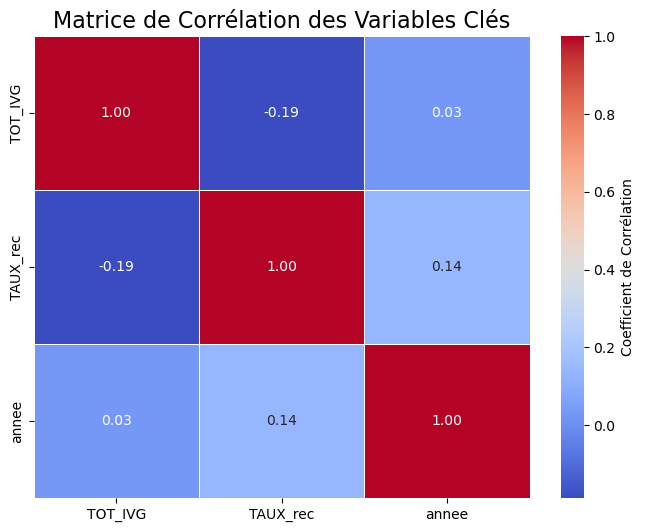

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Sélection des colonnes numériques
# Correction : Utilisation du nom de colonne correct 'TOT_IVG'
data_corr = df_cleaned[['TOT_IVG', 'TAUX_rec', 'annee']]

# 2. Calcul de la matrice de corrélation
correlation_matrix = data_corr.corr(method='pearson')

print("--- Matrice de Corrélation Numérique (Pearson) ---\n")
print(correlation_matrix)

# 3. Visualisation avec une Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,              # Afficher les valeurs de corrélation
    cmap='coolwarm',         # Palette de couleurs pour la visualisation
    fmt=".2f",               # Formater les nombres à 2 décimales
    linewidths=.5,
    cbar_kws={'label': 'Coefficient de Corrélation'}
)

plt.title('Matrice de Corrélation des Variables Clés', fontsize=16)
plt.show()